### Preparando o dataset para treino

In [14]:
! pip install libtiff
! pip install tifffile

ERROR: Operation cancelled by user


In [ ]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [15]:
# Executando no COLAB
uhcs_path = "/content/drive/MyDrive/data/Ultrahigh Carbon Steel Microconstituents Annotations/uhcs"
particles_path = "/content/drive/MyDrive/data/Ultrahigh Carbon Steel Microconstituents Annotations/particles"

In [10]:
# downloading database on windows
import requests
import zipfile

r = requests.get("https://materialsdata.nist.gov/bitstream/handle/11256/964/uhcs.zip?sequence=2&isAllowed=y")
with open('uchs.zip','wb') as f:
  f.write(r.content)
with zipfile.ZipFile('uchs.zip', 'r') as zip_ref:
    zip_ref.extractall('.\\')

r = requests.get("https://materialsdata.nist.gov/bitstream/handle/11256/964/particles.zip?sequence=3&isAllowed=y")
with open('particles.zip','wb') as f:
  f.write(r.content)
with zipfile.ZipFile('particles.zip', 'r') as zip_ref:
    zip_ref.extractall('.\\')

SSLError: ignored

In [6]:
# downloading database on linux
!wget "https://materialsdata.nist.gov/bitstream/handle/11256/964/uhcs.zip?sequence=2&isAllowed=y" -O uchs.zip
!unzip uchs
!wget "https://materialsdata.nist.gov/bitstream/handle/11256/964/particles.zip?sequence=3&isAllowed=y" -O particles.zip
!unzip particles

--2020-12-07 01:50:46--  https://materialsdata.nist.gov/bitstream/handle/11256/964/uhcs.zip?sequence=2&isAllowed=y
Resolving materialsdata.nist.gov (materialsdata.nist.gov)... 129.6.24.53, 2610:20:6005:24::53
Connecting to materialsdata.nist.gov (materialsdata.nist.gov)|129.6.24.53|:443... connected.
ERROR: cannot verify materialsdata.nist.gov's certificate, issued by ‘CN=DigiCert SHA2 Secure Server CA,O=DigiCert Inc,C=US’:
  Issued certificate has expired.
To connect to materialsdata.nist.gov insecurely, use `--no-check-certificate'.
Archive:  uchs.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of uchs.zip or
        uchs.zip.zip, and cannot find uchs.zip.ZIP, period.
--2020-12-07 01:50:47--  https://materialsdata.nist.gov/bitstream

In [16]:
import tifffile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import tifffile
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import os
import random
import pickle
from multilayer_perceptron import *
from hypercolumn import *

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

def one_hot_encode(labels, nclasses):
    l_shape = list(labels.shape)
    newshape = np.concatenate((l_shape, [nclasses]))
    onehot = np.zeros(newshape).astype(np.int8)
    for coordinates in cartesian([np.array(range(shape)) for shape in l_shape]):
        one_val = np.concatenate((coordinates, [int(labels[tuple(coordinates)])])) 
        onehot[tuple(one_val)] = 1
    return onehot

def one_hot_decode(label):
    l_shape = list(label.shape[:-1])
    decoded = np.zeros(l_shape).astype(np.int8)
    for coordinates in cartesian([np.array(range(dim)) for dim in l_shape]):
        decoded[tuple(coordinates)] = np.argmax(label[tuple(coordinates)])
    return np.squeeze(decoded)

# Selecionando a semente para gerar números pseudo-aleatórios
random.seed(10)
np.random.seed(10)

"""
Carregando imagens de UltraHigh Carbon Steel Database
"""
images = []
labels = []
images_dir = "uhcs/images"
labels_dir = "uhcs/labels"
for filename in os.listdir(images_dir):
    img = tifffile.imread(images_dir+"/"+filename)
    img = img[:484]
    img = np.stack((img,)*3, axis=-1)
    images.append(img)
X_uhcs_data = np.array(images)
images_tensor = tf.constant(images)
for filename in os.listdir(labels_dir):
    lbl = tifffile.imread(labels_dir+"/"+filename)
    lbl_zeros = np.zeros(lbl.shape)
    lbl = np.fmax(lbl_zeros,lbl)
    lbl = lbl[:484]
    lbl = one_hot_encode(lbl, 4)
    labels.append(lbl)
y_uhcs_data = np.array(labels)
labels_tensor = tf.constant(labels)
uhcs_data = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))

"""
Criando o Modelo
"""
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(484, 645, 3))
base_model.trainable = False
inputlayers = [
               'block1_conv2',
               'block2_conv2',
               'block3_conv3',
               'block4_conv3',
               'block5_conv3'
]
hc_model = build_hc_model(base_model, inputlayers)
pixelnet_model = build_model(hc_model, mc_dropout=True)

"""
Training the Model
"""
batchsize=1
opt = Adam()
loss_fn = CategoricalCrossentropy()
my_metrics = [
           CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)

path = ".\\saved_model"
if not os.path.isdir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("\nCreation of the directory %s failed \n" % path)
    else:
        print ("\nSuccessfully created the directory %s \n" % path)
else:
    print("\nDirectory %s already exists" % path)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('.\\tf_ckpts', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

uchs_history = pixelnet_model.fit(
    x = X_uhcs_data,
    y = y_uhcs_data,
    batch_size = batchsize,
    validation_split = 0.1,
    epochs = 100,
    verbose = 1,
    callbacks = [checkpoint, early_stopping, learning_rate_scheduler]
)

pixelnet_model.save(path, save_format='tf')
with open("X_uhcs_data.pickle","wb") as f:
    pickle.dump(X_uhcs_data, f)
with open("y_uhcs_data.pickle","wb") as f:
    pickle.dump(y_uhcs_data, f)

pixelnet_model.evaluate(X_uhcs_data, y_uhcs_data)

In [ ]:
img_1 = tifffile.imread('uhcs/images/uhcs0006.tif')

In [ ]:
img_1=img_1[:484]

In [ ]:
tifffile.imshow(img_1)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fc7b3ae8c88>)

In [ ]:
filehandler = open('structure.tiff', 'wb')
tifffile.imsave(filehandler, img_1)

In [ ]:
# convertendo 'grayscale' para '3-channel'
stacked_img_1 = np.stack((img_1,)*3, axis=-1)
tifffile.imshow(stacked_img_1)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f81116717f0>)

In [ ]:
print(stacked_img_1.shape)

(522, 645, 3)


In [ ]:
label_1 = np.array(tifffile.imread('uhcs/labels/uhcs0006.tif'))

In [17]:
import numpy as np

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [18]:
def one_hot_encode(labels, nclasses):
    l_shape = list(labels.shape)
    newshape = np.concatenate((l_shape, [nclasses]))
    onehot = np.zeros(newshape).astype(np.int8)
    for coordinates in cartesian([np.array(range(shape)) for shape in l_shape]):
        one_val = np.concatenate((coordinates, [int(labels[tuple(coordinates)])])) 
        onehot[tuple(one_val)] = 1
    return onehot

In [ ]:
tifffile.imshow(label_1)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fe5923ae2e8>)

In [ ]:
filehandler = open('label.tiff', 'wb')
tifffile.imsave(filehandler, label_1)

##### Carregando imagens para os Datasets e Arrays

In [19]:
import os
import tensorflow as tf

#carregando imagens de UltraHigh Carbon Steel Database
images = []
labels = []
images_dir = uhcs_path+"/images"
labels_dir = uhcs_path+"/labels"
for filename in os.listdir(images_dir):
    img = tifffile.imread(images_dir+"/"+filename)
    img = img[:484]
    img = np.stack((img,)*3, axis=-1)
    images.append(img)
X_uhcs_data = np.array(images)
images_tensor = tf.constant(images)
for filename in os.listdir(labels_dir):
    lbl = tifffile.imread(labels_dir+"/"+filename)
    lbl_zeros = np.zeros(lbl.shape)
    lbl = np.fmax(lbl_zeros,lbl)
    lbl = lbl[:484]
    lbl = one_hot_encode(lbl, 4)
    labels.append(lbl)
y_uhcs_data = np.array(labels)
labels_tensor = tf.constant(labels)
uhcs_data = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))

#carregando imagens de Particles Database
images = []
labels = []
images_dir = uhcs_path+"/images"
labels_dir = uhcs_path+"/labels"
for filename in os.listdir(images_dir):
    img = tifffile.imread(images_dir+"/"+filename)
    img = img[:484]
    img = np.stack((img,)*3, axis=-1)
    images.append(img)
X_particle_data = np.array(images)
images_tensor = tf.constant(images)
for filename in os.listdir(labels_dir):
    lbl = tifffile.imread(labels_dir+"/"+filename)
    lbl_zeros = np.zeros(lbl.shape)
    lbl = np.fmax(lbl_zeros,lbl)
    lbl = lbl[:484]
    lbl = one_hot_encode(lbl, 4)
    labels.append(lbl)
y_particle_data = np.array(labels)
labels_tensor = tf.constant(labels)
particle_data = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))

In [20]:
training_batches = uhcs_data.batch(batch_size=1, drop_remainder=False)

In [21]:
for image_batch, label_batch in training_batches.take(1):
    pass

image_batch.shape

TensorShape([1, 484, 645, 3])

### Criando o modelo

In [22]:
# create the model

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', 
                                         input_shape=(484, 645, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [23]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(1, 15, 20, 512)


In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 484, 645, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 484, 645, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 484, 645, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 242, 322, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 242, 322, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 242, 322, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 121, 161, 128)     0     

In [26]:
# criando o mapeamento das features de cada maxpoolinglayer para a "hipercoluna"
# baseado no modelo relatado no artigo em https://arxiv.org/pdf/1805.08693.pdf
# Código disponível em: https://github.com/bdecost/pixelnet/blob/master/pixelnet
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
import tensorflow.keras.backend as K

def get_values(data, batch, x, y):
    """ construct index tensor for tf.gather_nd """
    coords = tf.stack((batch, x, y), 2)
    indices = tf.cast(coords, tf.int32)
    return tf.gather_nd(data, indices)

def offset(x1, x2):
    """ helper for bilinear upsample:
    make offset tensor the same rank as data tensor for broadcasting.
    """
    dx = x2 - x1
    return tf.expand_dims(dx, axis=-1)

def sparse_upsample_bilinear(inputs, **arguments):
    """ upsample the input tensor `data` with indices in input tensor sel
    performs sparse bilinear interpolation
    indices should explicitly contain the sample index: (b, i, j)
    """
    data, coords = inputs
    w = tf.cast(tf.shape(data)[1], tf.float32)
    h = tf.cast(tf.shape(data)[2], tf.float32)

    # transform fractional coordinates to feature map coordinates
    batch = coords[:,:,0]
    x = w * coords[:,:,1]
    y = h * coords[:,:,2]

    # clip feature map coordinates
    # results in incorrect interpolation
    # for samples in the last row and/or column
    x1, y1 = tf.math.floor(x), tf.math.floor(y)
    x1 = tf.clip_by_value(x1, 0, w-3)
    y1 = tf.clip_by_value(y1, 0, h-3)
    x2, y2 = 1 + x1, 1 + y1

    # horizontal interpolation first
    top = get_values(data, batch, x1, y2) * offset(x, x2) +  get_values(data, batch, x2, y2) * offset(x1, x)
    bottom = get_values(data, batch, x1, y1) * offset(x, x2)  + get_values(data, batch, x2, y1) * offset(x1, x)

    # vertical interpolation
    interp =  bottom * offset(y, y2) + top * offset(y1, y)
    return interp

def sparse_upsample_output_shape(input_shape):
    # sparse_upsample expects two input tensors:
    # the feature map tensor and an index tensor
    data_shape, index_shape = input_shape
    assert K.backend() == 'tensorflow'
    assert len(data_shape) == 4 # only valid for 4D tensors
    assert len(index_shape) == 3
    return (data_shape[0], index_shape[0], data_shape[3])

def random_foreground_indices(L, npix=4096, bgval=-1):
    """ Sample random foreground pixels from 3D label array L: return indices (including batch index)
    same number of pixels from each image so that the samples fit into the coordinate/output tensors
    npix=4096 yields ~2% of foreground pixels in 1024x1024 particle micrograph inputs
    """
    n, h, w = L.shape
    
    # sample coordinates should include the batch index for tf.gather_nd
    ind = []

    for idx in range(n):
        # get coordinates for all foreground pixels
        y, x = np.where(L[idx] > bgval)
        minibatch = np.ones(x.size) * idx
        pixels = np.stack((minibatch, x/w, y/h), axis=1)
        
        # get a random subset
        idx = np.random.choice(range(pixels.shape[0]), npix)
        ind.append(pixels[idx])
    
    return np.stack(ind, axis=0)

def build_hc_model(base_model, input_layers, mode='dense', batchnorm=False, relu=True):
    inputdata = base_model.input
    
    batchsize, h, w = inputdata.shape[0], inputdata.shape[1], inputdata.shape[2]
    
    X = [base_model.get_layer(layername).output for layername in input_layers]

    if batchnorm:
        X = [
            tf.keras.layers.BatchNormalization(scale=False, name='{}_bn'.format(name))(x)
            for x, name in zip(X, input_layers)
            ]

    if relu:
        X = [tf.keras.layers.Activation('relu')(x) for x in X]

    if mode == 'dense':
        inputs = inputdata
        upsample = tf.keras.layers.Lambda(
            lambda t: tf.image.resize(t, [h,w]),
            output_shape=lambda s: (s[0], h, w, s[-1]),
            name='tf_upsample'
        )

        hc_layers = [upsample(x) for x in X]


    elif mode == 'sparse':
        inputcoords = Input(shape=(None, 3,), dtype='float32')
        inputs = [inputdata, inputcoords]
        upsample = Lambda(
            sparse_upsample_bilinear,
            output_shape=sparse_upsample_output_shape,
            name='sparse_upsample'
        )
    
        hc_layers = [upsample([x, inputcoords]) for x in X]

    hc = tf.keras.layers.Concatenate(axis=-1, name='hypercolumn')(hc_layers)

    # hc = tf.reshape(hc, (batchsize, h, w, -1))
    
    return tf.keras.Model(inputs, hc)

In [27]:
inputlayers = [
               'block1_conv2',
               'block2_conv2',
               'block3_conv3',
               'block4_conv3',
               'block5_conv3'
]

hc_model = build_hc_model(base_model, inputlayers)

In [28]:
hypercolumn_batch = hc_model(image_batch)

In [29]:
hypercolumn_batch.shape

TensorShape([1, 484, 645, 1472])

In [ ]:
hc_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 484, 645, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 484, 645, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 484, 645, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 242, 322, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(hc_model, "Hiper_column_model.png", show_shapes=True)

In [30]:
# contruindo a MLP (MultiLayer Perceptron)
# retirado de: https://github.com/bdecost/pixelnet/blob/master/pixelnet/pixelnet.py

init = initializers.VarianceScaling(
    scale=0.5,
    mode='fan_in',
    distribution='normal'
)

def dense_bn(x, channels, name=None, l2_reg=1e-4):
    x = layers.Dense(channels, use_bias=False, name='{}_fc'.format(name), kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization(scale=True, name='{}_bn'.format(name))(x)
    return layers.Activation('relu', name=name)(x)

def dense_selu(x, channels, name=None, l2_reg=1e-4):
    x = layers.Dense(channels, name='{}/fc'.format(name), kernel_initializer=init, kernel_regularizer=regularizers.l2(l2_reg))(x)
    return layers.Activation('selu', name=name+'/selu')(x)

def flatten_pixels(nchannels):
    """ rearrange hypercolumns into a pixelwise data matrix """

    flatten = layers.Lambda(
        lambda t: layers.Reshape((-1, nchannels))(t),
        output_shape=lambda s: (-1, s[-1]),
        name='flatten_pixel_features'
    )
    return flatten

def unflatten_pixels(inputs, nclasses=4, mode='dense'):
    
    if mode not in ('sparse', 'dense'):
        raise NotImplementedError
    
    if mode == 'dense':
        inputdata, = inputs
    elif mode == 'sparse':
        inputdata, inputcoord = inputs
        
    batchsize, h, w = inputdata.shape[0], inputdata.shape[1], inputdata.shape[2]
    
    if mode == 'dense':
        # note: output_shape wants the static shape (None, None, None, nclasses)
        # but reshape needs the dynamic shape (int, int, int, nclasses)

        b_dyn, h_dyn, w_dyn, _ = inputdata.shape
        unflatten = layers.Lambda(
            lambda t: layers.Reshape((h, w, nclasses))(t),
            output_shape=lambda s: (b_dyn, h_dyn, w_dyn, nclasses),
            name='unflatten_pixel_features'
        )
    elif mode == 'sparse':
        # note: output_shape wants the static shape (None, None, nclasses)
        # but reshape needs the dynamic shape (int, int, nclasses)
        # actually, batchsize can be either, but npix needs to be the dynamic value.
        npix = K.shape(inputcoord)[1]
        _, npix_dyn, _ = inputcoord.shape
        unflatten = layers.Lambda(
            lambda t: layers.Reshape((npix, nclasses))(t),
            # output_shape=lambda s: (4, 2048, nclasses),
            output_shape=lambda s: (batchsize, npix_dyn, nclasses),
            name='unflatten_pixel_features'
        )
        
    return unflatten

In [31]:
def build_model(hc_model, width=1024, depth=2, dropout_rate=0.5, nclasses=4, mode='dense', activation='softmax', selu=False, mc_dropout=False, l2_reg=1e-4):
    """ PixelNet: define an MLP model over a hypercolumn model given as input 
    @article{pixelnet,
      title={Pixel{N}et: {R}epresentation of the pixels, by the pixels, and for the pixels},
      author={Bansal, Aayush
              and Chen, Xinlei,
              and  Russell, Bryan
              and Gupta, Abhinav
              and Ramanan, Deva},
      Journal={arXiv preprint arXiv:1702.06506},
      year={2017}
    }
    From the paper and their notes on github, it seems like the semantic segmentation
    task should work either with linear classifier + BatchNorm, or with MLP without BatchNorm.
    activation: activation function for prediction layer. 'softmax' for classification, 'linear' for regression. """

    x = hc_model.output
    nchannels = x.shape[-1]
    x = flatten_pixels(nchannels)(x)

    if selu:
        for idx in range(depth):
            x = dense_selu(x, width, name='mlp{}'.format(idx+1), l2_reg=l2_reg)
            x = layers.AlphaDropout(dropout_rate)(x)
    else:
        for idx in range(depth):
            x = dense_bn(x, width, name='mlp{}'.format(idx+1), l2_reg=l2_reg)
            x = layers.Dropout(dropout_rate)(x, training=mc_dropout)

    x = layers.Dense(nclasses, activation=activation, name='predictions')(x)
    
    x = unflatten_pixels(hc_model.inputs, nclasses=nclasses, mode=mode)(x)

    return models.Model(inputs=hc_model.inputs, outputs=x)

In [32]:
pixelnet_model = build_model(hc_model, mc_dropout=True)

In [ ]:
pixelnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 484, 645, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 484, 645, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 484, 645, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 242, 322, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

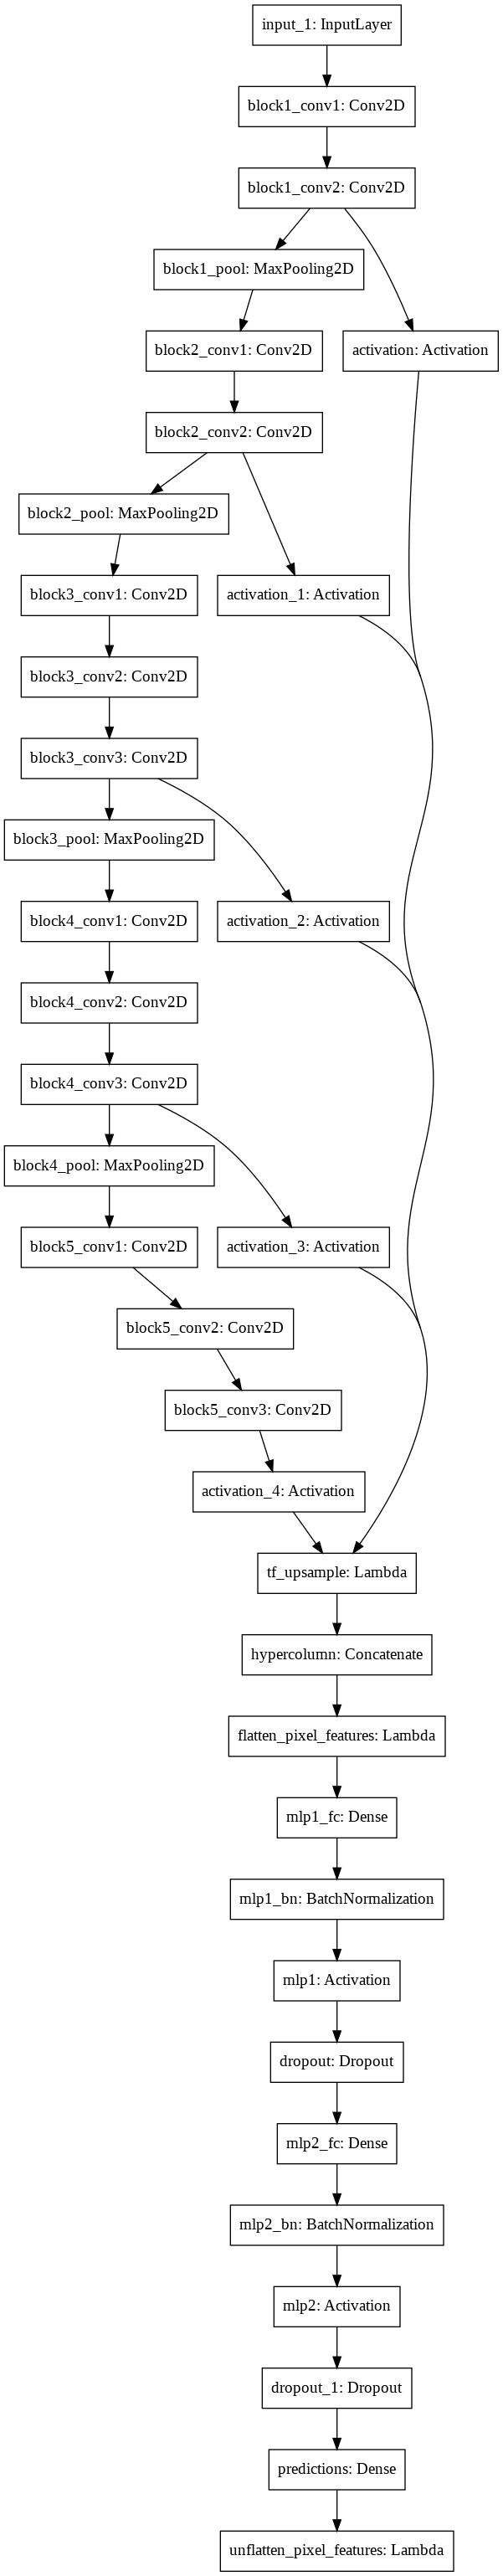

In [35]:
tf.keras.utils.plot_model(pixelnet_model, "./Pixelnet_model.png", show_shapes=False)

In [ ]:
# testando o modelo:

predict_batch = pixelnet_model(image_batch)

In [ ]:
predict_batch.shape

TensorShape([1, 484, 645, 4])

### Treinando o Modelo

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

batchsize=1
opt = Adam()
loss_fn = CategoricalCrossentropy()
my_metrics = [
           CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)

path = ".\\saved_model"
if not os.path.isdir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("\nCreation of the directory %s failed \n" % path)
    else:
        print ("\nSuccessfully created the directory %s \n" % path)
else:
    print("\nDirectory %s already exists" % path)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('.\\tf_ckpts', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

uchs_history = pixelnet_model.fit(
    x = X_uhcs_data,
    y = y_uhcs_data,
    batch_size = batchsize,
    validation_split = 0.1,
    epochs = 100,
    verbose = 1,
    callbacks = [checkpoint, early_stopping, learning_rate_scheduler]
)

pixelnet_model.save(path, save_format='tf')

import json
json_config = pixelnet_model.to_json()
with open('model_architecture.json','w') as outfile:
    json.dump(json_config, outfile)

pixelnet_model.save_weights_only(path, save_format='h5')


Directory .\saved_model already exists
Epoch 1/100
21/21 [==============================] - 389s 19s/step - loss: 0.5286 - categorical_accuracy: 0.8716 - val_loss: 1.4282 - val_categorical_accuracy: 0.8419 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 389s 19s/step - loss: 0.5263 - categorical_accuracy: 0.8577 - val_loss: 0.7168 - val_categorical_accuracy: 0.8708 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 388s 18s/step - loss: 0.4292 - categorical_accuracy: 0.8964 - val_loss: 0.6060 - val_categorical_accuracy: 0.8701 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 387s 18s/step - loss: 0.3971 - categorical_accuracy: 0.9055 - val_loss: 0.5794 - val_categorical_accuracy: 0.8653 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 387s 18s/step - loss: 0.3871 - categorical_accuracy: 0.9065 - val_loss: 0.4786 - val_categorical_accuracy: 0.8832 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 387s 18

### Testando o Modelo

In [ ]:
# Loading saved model
import tensorflow as tf
loaded_model = tf.saved_model.load('/content/drive/My Drive/data/teste_lucas/saved_model/')

In [ ]:
loaded_variables = loaded_model.variables

In [ ]:
pixelnet_weights = pixelnet_model.get_weights()

In [ ]:
assert len(loaded_variables) == len(pixelnet_weights)

In [ ]:
loaded_weights = [var.numpy() for var in loaded_variables]

In [ ]:
pixelnet_model.set_weights(loaded_weights)

In [ ]:
def one_hot_decode(label):
    l_shape = list(label.shape[:-1])
    decoded = np.zeros(l_shape).astype(np.int8)
    for coordinates in cartesian([np.array(range(dim)) for dim in l_shape]):
        decoded[tuple(coordinates)] = np.argmax(label[tuple(coordinates)])
    return np.squeeze(decoded)

In [ ]:
predicted_labels = one_hot_decode(pixelnet_model.predict(np.expand_dims(X_uhcs_data[0],axis=0)))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f81116a7198>)

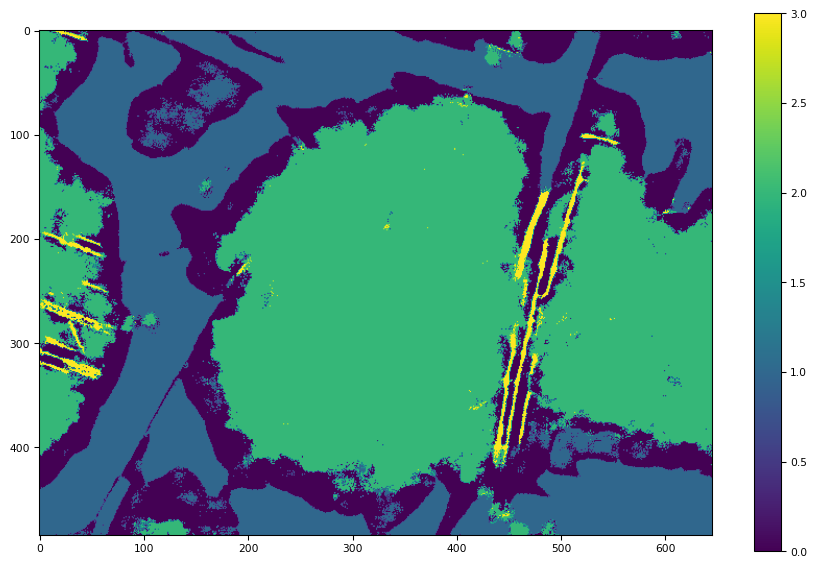

In [ ]:
tifffile.imshow(predicted_label)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f81094a9518>)

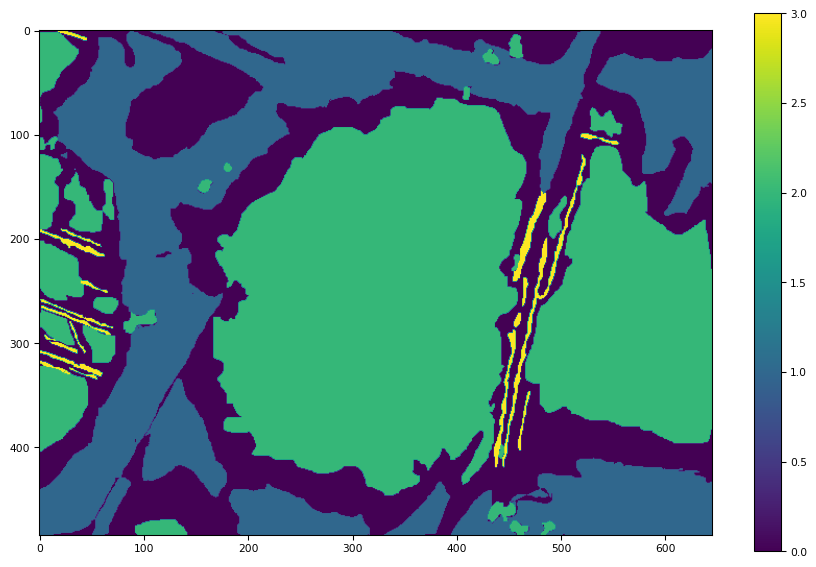

In [ ]:
tifffile.imshow(one_hot_decode(y_uhcs_data[0]))

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)

In [ ]:
pixelnet_model.evaluate(X_uhcs_data, y_uhcs_data)

### Utilizando "image augmentation"

In [ ]:
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to c:\users\gilen\appdata\local\temp\pip-req-build-in0fhxbm
  Created wheel for imgaug: filename=imgaug-0.4.0-py3-none-any.whl size=964278 sha256=54fad7e5267a453124068b5340592fbb5ae47f70cbd3d36673a1f6152093af81
  Stored in directory: C:\Users\gilen\AppData\Local\Temp\pip-ephem-wheel-cache-jl6u3bkz\wheels\0c\78\b5\9303fae9d5e03df1f319adfe4e6534180b5c3232de11bc9a2f
Successfully built imgaug


You should consider upgrading via the 'c:\users\gilen\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
#importando a biblioteca de image augmentation
import imgaug
import imgaug.augmenters as iaa

def create_aug(randstate):
    aug = iaa.Sequential( 
        [
        iaa.CropAndPad(percent=(-0.25,0.10), seed=randstate),
        iaa.Fliplr(0.5, seed=randstate),
        iaa.Flipud(0.5, seed=randstate),
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0.0,1.5), seed=randstate),
            seed=randstate
        ),
        iaa.Sometimes(
            0.5,
            iaa.MedianPooling(kernel_size=(1,2), seed=randstate),
            seed=randstate
        ),
        iaa.LinearContrast(alpha=(0.8,1.2), seed=randstate),
        iaa.Multiply(mul=(0.8,1.2), seed=randstate)
        ],
        random_order=True,
        seed=randstate
    )
    return aug

def augment_images(images, labels):
    new_images = []
    new_labels = []
    seed_list = [123,567,892,564,210,23,64,589]
    for seed in seed_list:
        aug = create_aug(seed)
        for img in aug(images=images):
            new_images.append(img)
        aug2 = create_aug(seed)
        for lbl in aug2(images=labels):        
            new_labels.append(lbl)
    new_images = np.concatenate((new_images, images))
    new_labels = np.concatenate((new_labels, labels))
    return new_images, new_labels

X_uhcs_aug, y_uhcs_aug = augment_images(X_uhcs_data, y_uhcs_data)

In [ ]:
#salvando as imagens com augmentation para posterior uso
np.savez("augmented_uhcs_images_and_labels.npz", X_uhcs_data, y_uhcs_data)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x247dea6b088>)

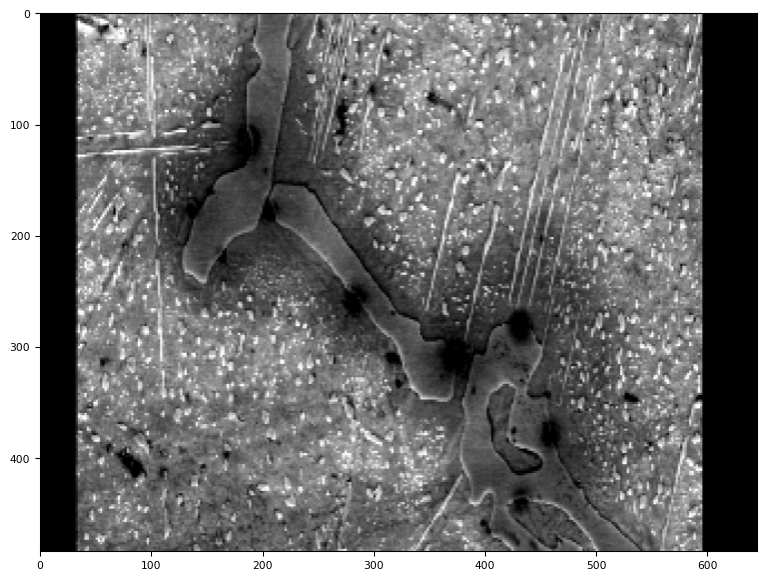

In [ ]:
tifffile.imshow(X_uhcs_aug[159])

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x247de3a6548>)

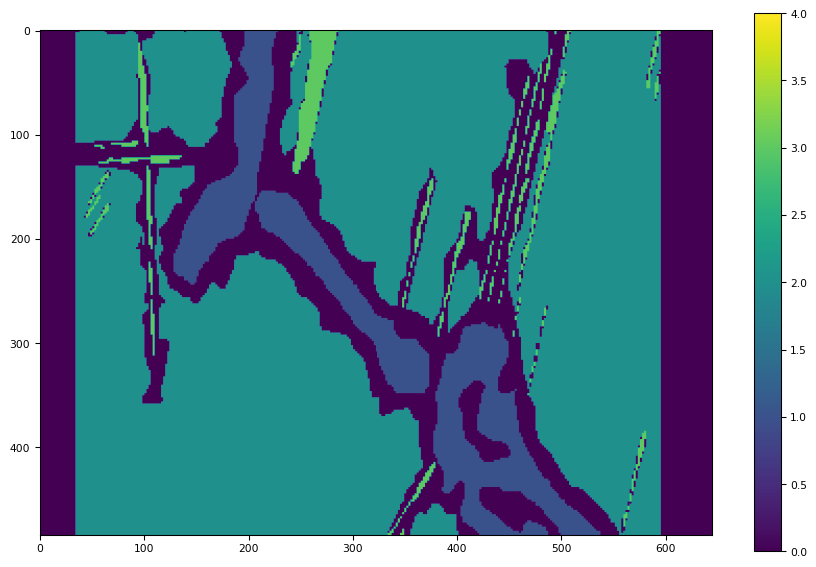

In [ ]:
tifffile.imshow(one_hot_decode(y_uhcs_aug[159]))

In [ ]:
# create a new model to train on augmented dataset
pixelnet_aug_model = build_model(hc_model, mc_dropout=True)

##### Retreinando o modelo

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

batchsize=1
opt = Adam()
loss_fn = CategoricalCrossentropy()
my_metrics = [
           CategoricalAccuracy()
]
pixelnet_aug_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)

path = ".\\saved_aug_model"
if not os.path.isdir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("\nCreation of the directory %s failed \n" % path)
    else:
        print ("\nSuccessfully created the directory %s \n" % path)
else:
    print("\nDirectory %s already exists" % path)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('.\\tf_aug_ckpts', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

uchs_history = pixelnet_aug_model.fit(
    x = X_uhcs_aug,
    y = y_uhcs_aug,
    batch_size = batchsize,
    validation_split = 0.1,
    epochs = 100,
    verbose = 1,
    callbacks = [checkpoint, early_stopping, learning_rate_scheduler]
)

pixelnet_aug_model.save(path, save_format='tf')

import json
json_config = pixelnet_aug_model.to_json()
with open('pixelnet_aug_arch.json','w') as outfile:
    json.dump(json_config, outfile)

pixelnet_aug_model.save_weights('pixelnet_aug_arch.h5', save_format='h5')


Directory .\saved_aug_model already exists
Epoch 1/100
194/194 [==============================] - 3823s 20s/step - loss: 0.5767 - categorical_accuracy: 0.8007 - val_loss: 0.6739 - val_categorical_accuracy: 0.8446 - lr: 0.0010
Epoch 2/100
194/194 [==============================] - 3823s 20s/step - loss: 0.4129 - categorical_accuracy: 0.8414 - val_loss: 0.5298 - val_categorical_accuracy: 0.8492 - lr: 0.0010
Epoch 3/100
194/194 [==============================] - 3834s 20s/step - loss: 0.3546 - categorical_accuracy: 0.8581 - val_loss: 0.5859 - val_categorical_accuracy: 0.8477 - lr: 0.0010
Epoch 4/100
194/194 [==============================] - 3836s 20s/step - loss: 0.3278 - categorical_accuracy: 0.8632 - val_loss: 0.3564 - val_categorical_accuracy: 0.8915 - lr: 0.0010
Epoch 5/100
194/194 [==============================] - 3815s 20s/step - loss: 0.3108 - categorical_accuracy: 0.8581 - val_loss: 0.4155 - val_categorical_accuracy: 0.8799 - lr: 0.0010
Epoch 6/100
194/194 [====================

OSError: ignored

##### Testando o modelo com "augmentation"

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x2483defb7c8>)

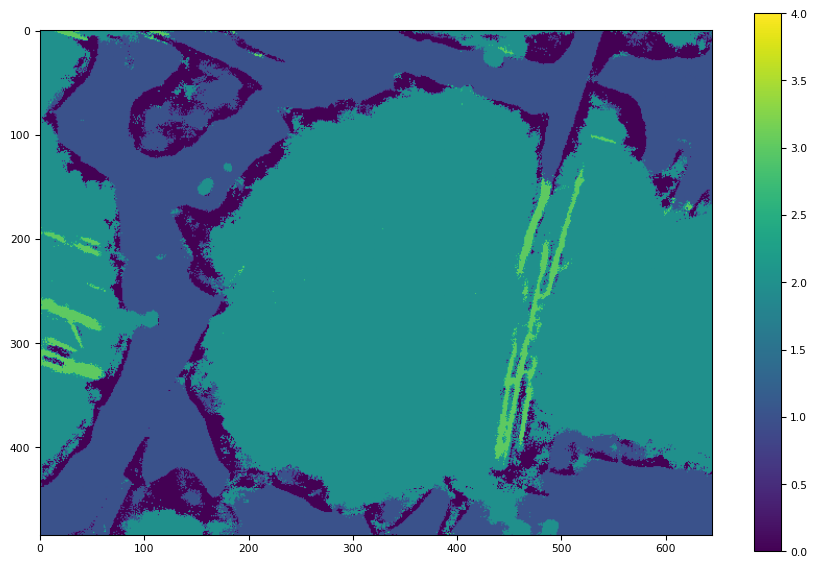

In [ ]:
tifffile.imshow(one_hot_decode(pixelnet_aug_model.predict(np.expand_dims(X_uhcs_data[0], axis=0))))

In [ ]:
# Loading saved aug model
import tensorflow as tf
loaded_model = tf.saved_model.load('/content/drive/My Drive/data/teste_lucas/saved_aug_model/')

In [ ]:
loaded_weights = [var.numpy() for var in loaded_model.variables]

In [ ]:
pixelnet_aug_model = build_model(hc_model, mc_dropout=True)

In [ ]:
pixelnet_aug_model.set_weights(loaded_weights)

In [ ]:
tifffile.imshow(one_hot_decode(pixelnet_aug_model.predict(np.expand_dims(X_uhcs_data[0], axis=0))))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f6f49102c18>)

In [ ]:
tifffile.imshow(X_uhcs_data[0])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f6f49021d68>)

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_model.evaluate(X_uhcs_data, y_uhcs_data, batch_size=1)

24/24 [==============================] - 761s 32s/step - loss: 0.3158 - categorical_accuracy: 0.9082


[0.31584814190864563, 0.9081830382347107]

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_aug_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_aug_model.evaluate(X_uhcs_data, y_uhcs_data, batch_size=1)

24/24 [==============================] - 761s 32s/step - loss: 0.5738 - categorical_accuracy: 0.8554


[0.5738068222999573, 0.8554111123085022]

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_model.evaluate(X_uhcs_aug, y_uhcs_aug, batch_size=1)

216/216 [==============================] - 7115s 33s/step - loss: 1.1086 - categorical_accuracy: 0.6233


[1.1086472272872925, 0.6233459115028381]

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_aug_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_aug_model.evaluate(X_uhcs_aug, y_uhcs_aug, batch_size=1)

216/216 [==============================] - 7104s 33s/step - loss: 0.5356 - categorical_accuracy: 0.7879


[0.5356070399284363, 0.7878575921058655]

In [ ]:
import numpy as np

In [ ]:
tifffile.imshow(one_hot_decode(pixelnet_aug_model.predict(np.expand_dims(X_uhcs_aug[0], axis=0))))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2abd0d4d30>)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2ab6eb3630>)

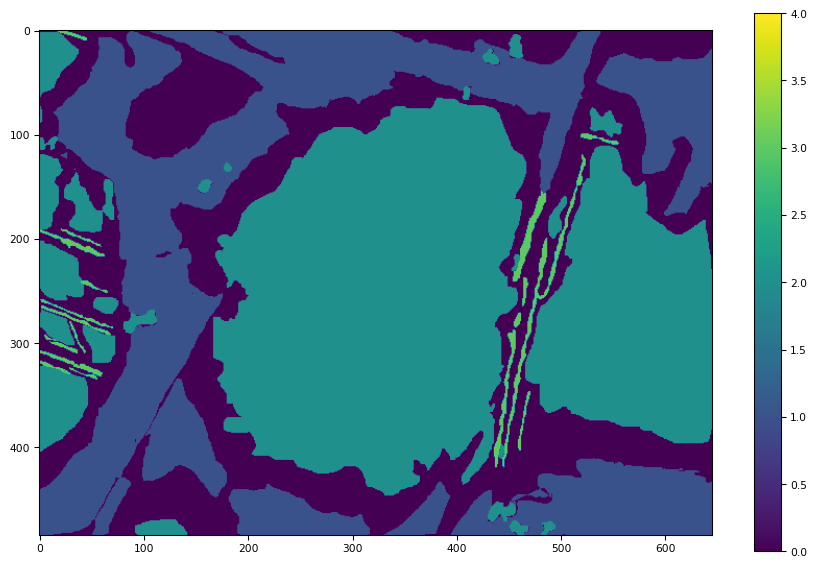

In [ ]:
tifffile.imshow(one_hot_decode(y_uhcs_aug[0]))

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f82213abe10>)

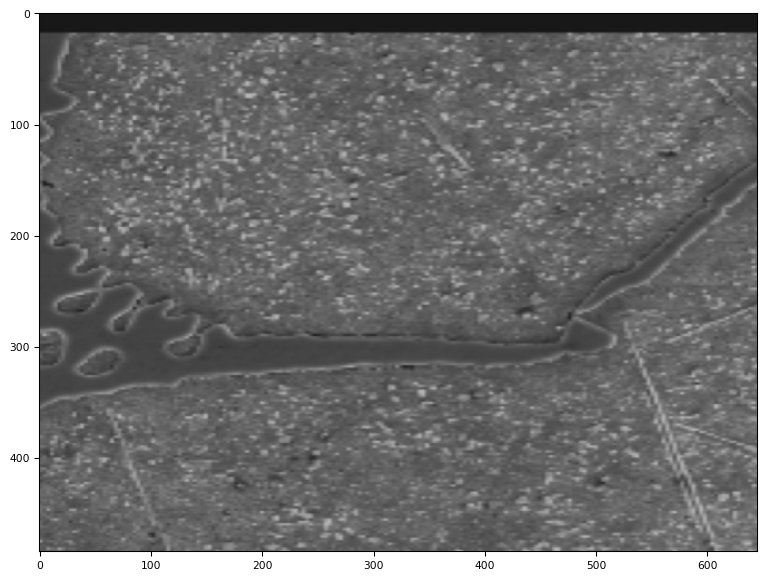

In [ ]:
tifffile.imshow(X_uhcs_aug[0])

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f8222b87240>)

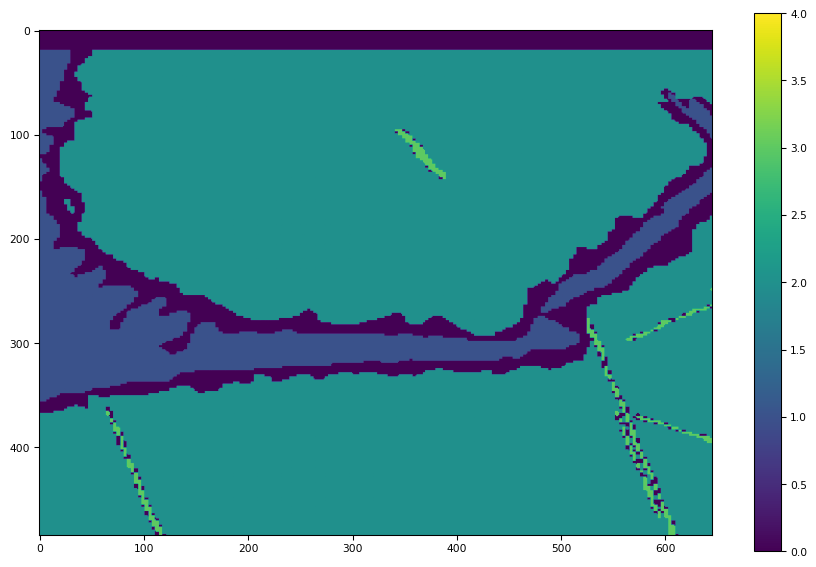

In [ ]:
tifffile.imshow(one_hot_decode(y_uhcs_aug[0]))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f82214d86d8>)

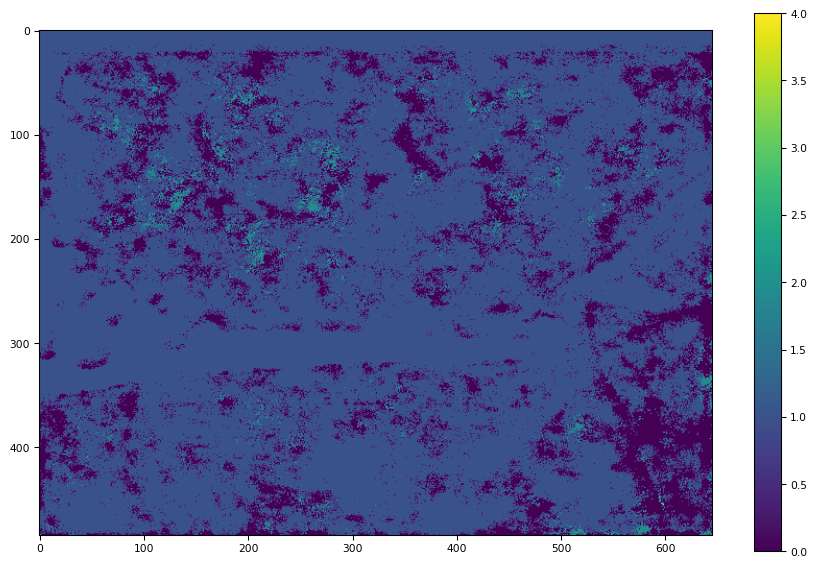

In [ ]:
tifffile.imshow(one_hot_decode(pixelnet_model.predict(np.expand_dims(X_uhcs_aug[0], axis=0))))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f82212b1278>)

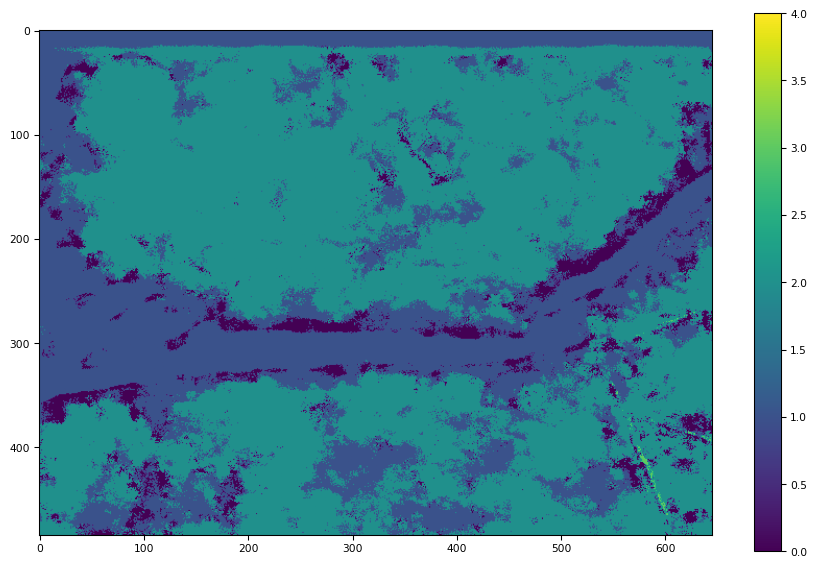

In [ ]:
tifffile.imshow(one_hot_decode(pixelnet_aug_model.predict(np.expand_dims(X_uhcs_aug[0], axis=0))))

### Usando "image augmentation" pela segunda vez


In [ ]:
# Nova tentativa com augmentation
#importando a biblioteca de image augmentation
import imgaug
import imgaug.augmenters as iaa

def create_aug(randstate):
    aug = iaa.SomeOf(
        2,
        [
        iaa.CropAndPad(percent=(-0.25,0.10), seed=randstate),
        iaa.Fliplr(0.5, seed=randstate),
        iaa.Flipud(0.5, seed=randstate),
        iaa.GaussianBlur(sigma=(0.0,1.0), seed=randstate),
        iaa.MedianPooling(kernel_size=(1,2), seed=randstate),
        iaa.LinearContrast(alpha=(0.8,1.2), seed=randstate),
        iaa.Multiply(mul=(0.8,1.2), seed=randstate)
        ],
        random_order=True,
        seed=randstate
    )
    return aug

def augment_images(images, labels, n_size):
    new_images = []
    new_labels = []
    seed_list = np.random.randint(
        low=100,
        high=1000,
        size=(n_size,)
    )
    for seed in seed_list:
        aug = create_aug(seed)
        for img in aug(images=images):
            new_images.append(img)
        aug2 = create_aug(seed)
        for lbl in aug2(images=labels):        
            new_labels.append(lbl)
    new_images = np.concatenate((new_images, images))
    new_labels = np.concatenate((new_labels, labels))
    return new_images, new_labels

X_uhcs_aug2, y_uhcs_aug2 = augment_images(X_uhcs_data, y_uhcs_data, 4)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f8788454470>)

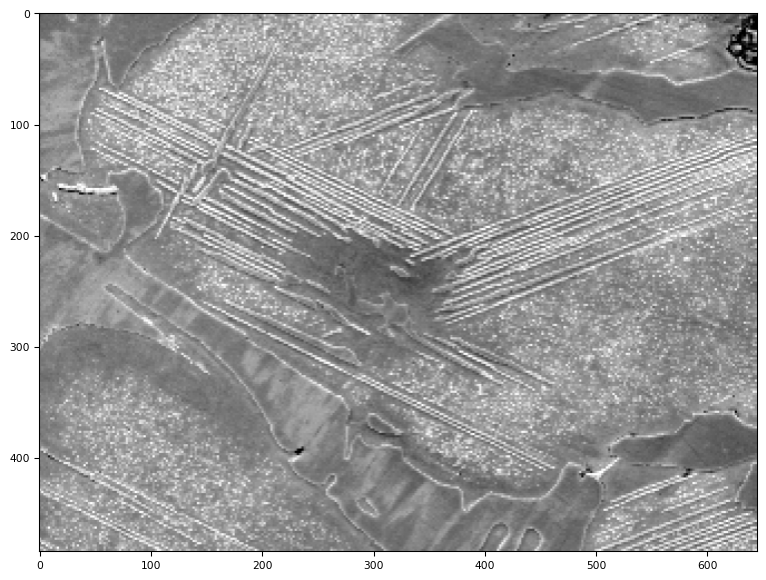

In [ ]:
tifffile.imshow(X_uhcs_aug2[1])

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f87884335f8>)

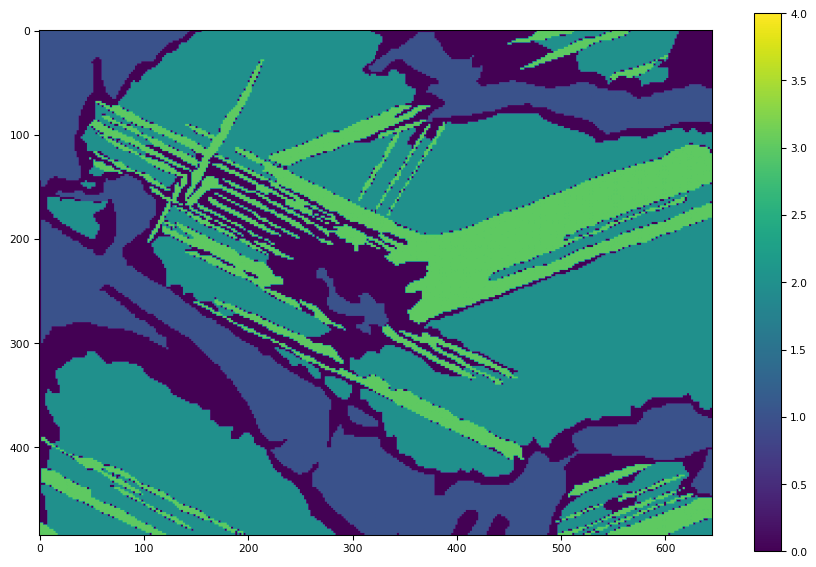

In [ ]:
tifffile.imshow(one_hot_decode(y_uhcs_aug2[1]))

In [ ]:
import numpy as np
np.savez_compressed('.\\Augmented_data2.npz',X_uhcs_aug2, y_uhcs_aug2)

In [ ]:
y_uhcs_aug.shape

(120, 484, 645, 4)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

pixelnet_aug2_model = build_model(hc_model, mc_dropout=True)

batchsize=1
opt = Adam()
loss_fn = CategoricalCrossentropy()
my_metrics = [
           CategoricalAccuracy()
]
pixelnet_aug2_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)

path = "saved_aug2_model/"
if not os.path.isdir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("\nCreation of the directory %s failed \n" % path)
    else:
        print ("\nSuccessfully created the directory %s \n" % path)
else:
    print("\nDirectory %s already exists" % path)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('tf_aug2_ckpts/', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

uchs_history = pixelnet_aug2_model.fit(
    x = X_uhcs_aug2,
    y = y_uhcs_aug2,
    batch_size = batchsize,
    validation_split = 0.1,
    epochs = 100,
    verbose = 1,
    callbacks = [checkpoint, early_stopping, learning_rate_scheduler]
)

pixelnet_aug2_model.save(path, save_format='tf')

import json
json_config = pixelnet_aug2_model.to_json()
with open('pixelnet_aug2_arch.json','w') as outfile:
    json.dump(json_config, outfile)

pixelnet_aug2_model.save_weights('pixelnet_aug2_arch.h5', save_format='h5')


Directory saved_aug2_model/ already exists
Epoch 1/100
108/108 [==============================] - 1993s 18s/step - loss: 0.6684 - categorical_accuracy: 0.8161 - val_loss: 1.0859 - val_categorical_accuracy: 0.8103 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - 1992s 18s/step - loss: 0.4413 - categorical_accuracy: 0.8760 - val_loss: 0.6311 - val_categorical_accuracy: 0.8559 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - 1972s 18s/step - loss: 0.3961 - categorical_accuracy: 0.8843 - val_loss: 0.3941 - val_categorical_accuracy: 0.8956 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - 1950s 18s/step - loss: 0.3535 - categorical_accuracy: 0.8923 - val_loss: 0.3732 - val_categorical_accuracy: 0.9011 - lr: 0.0010
Epoch 5/100
108/108 [==============================] - 1950s 18s/step - loss: 0.3423 - categorical_accuracy: 0.8906 - val_loss: 0.3255 - val_categorical_accuracy: 0.9129 - lr: 0.0010
Epoch 6/100
108/108 [====================

In [ ]:
import numpy as np
data_dir = '/content/drive/My Drive/data'
aug_data2 = np.load(f'{data_dir}/Augmented_data2.npz', allow_pickle=True)

In [ ]:
X_uhcs_aug2 = aug_data2['arr_0']
y_uhcs_aug2 = aug_data2['arr_1']

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fc7a3786470>)

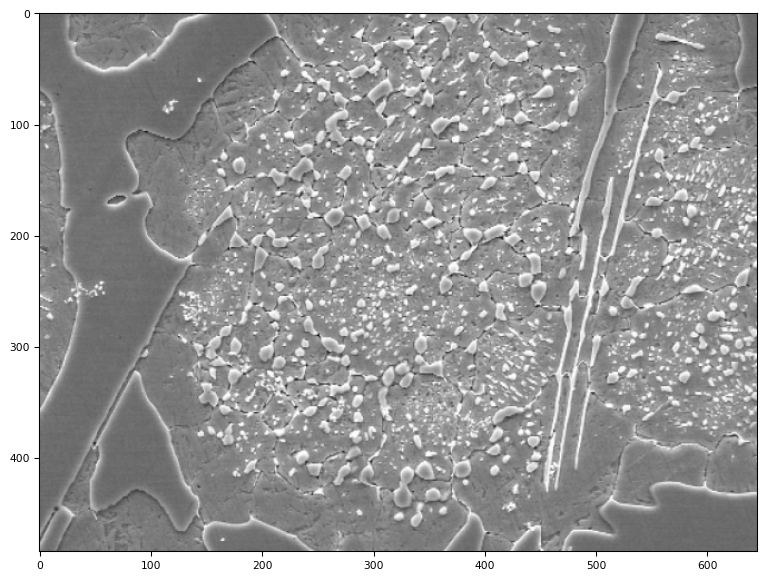

In [ ]:
tifffile.imshow(X_uhcs_aug2[0])

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fc7a12125c0>)

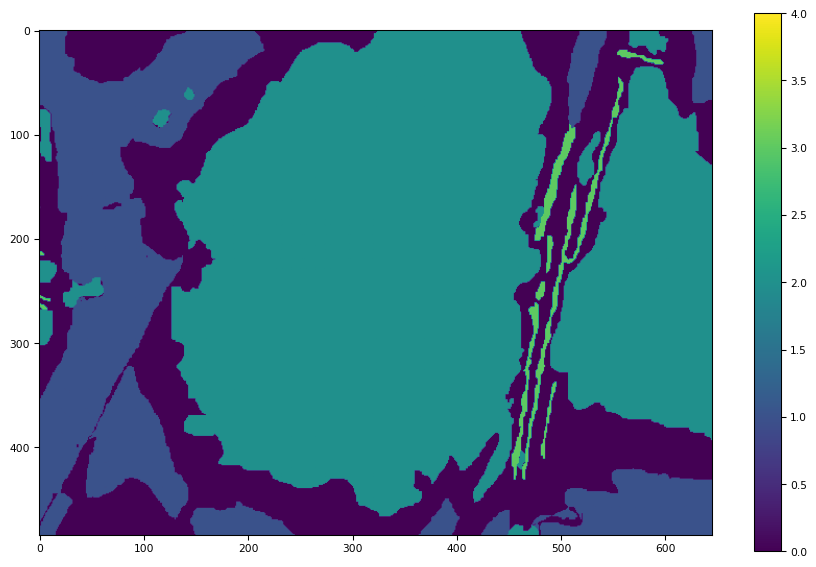

In [ ]:
tifffile.imshow(one_hot_decode(y_uhcs_aug2[0]))

In [ ]:
X_uhcs_data2[0].shape

(484, 645, 3)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f1ff9bcecf8>)

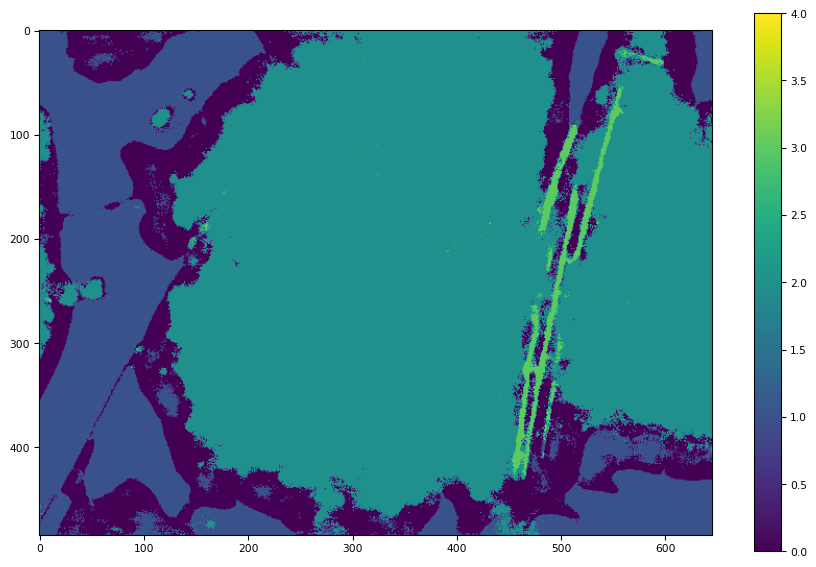

In [ ]:
loaded_model = tf.saved_model.load(f'{data_dir}/saved_aug2_model/')
loaded_weights = [var.numpy() for var in loaded_model.variables]
pixelnet_aug2_model = build_model(hc_model, mc_dropout=True)
pixelnet_aug2_model.set_weights(loaded_weights)
tifffile.imshow(one_hot_decode(pixelnet_aug2_model.predict(np.expand_dims(X_uhcs_aug2[0], axis=0))))

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_aug2_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_aug2_model.evaluate(X_uhcs_aug2, y_uhcs_aug2, batch_size=1)

120/120 [==============================] - 3985s 33s/step - loss: 0.3123 - categorical_accuracy: 0.8903


[0.31229403614997864, 0.890318751335144]

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_aug2_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_aug2_model.evaluate(X_uhcs_data, y_uhcs_data, batch_size=1)

24/24 [==============================] - 817s 34s/step - loss: 0.3304 - categorical_accuracy: 0.9036


[0.3304399847984314, 0.9035800695419312]

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_model.evaluate(X_uhcs_data, y_uhcs_data, batch_size=1)

24/24 [==============================] - 813s 34s/step - loss: 0.3159 - categorical_accuracy: 0.9082


[0.31590184569358826, 0.9081775546073914]

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
my_metrics = [
           tf.keras.metrics.CategoricalAccuracy()
]
pixelnet_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)
pixelnet_model.evaluate(X_uhcs_aug2, y_uhcs_aug2, batch_size=1)

120/120 [==============================] - 4511s 38s/step - loss: 0.4770 - categorical_accuracy: 0.8306


[0.4769635498523712, 0.8305861353874207]

### Usando a API de detecção de objetos do TensorFlow

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2168, done.
remote: Counting objects: 100% (2168/2168), done.
remote: Compressing objects: 100% (1874/1874), done.
remote: Total 2168 (delta 515), reused 926 (delta 270), pack-reused 0
Receiving objects: 100% (2168/2168), 30.39 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (515/515), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1571721 sha256=7080e1e34fcd885f6e368668cebeca480e1ffa95b0a8949826c22be45c6720d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-uh9f7l_g/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-09-12 19:00:48--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   200MB/s    in 1.2s    

2020-09-12 19:00:50 (200 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
detection_model.summary()

AttributeError: ignored